# MNIST Dataset for Federated Learning

## Visualize Dataset

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 145kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



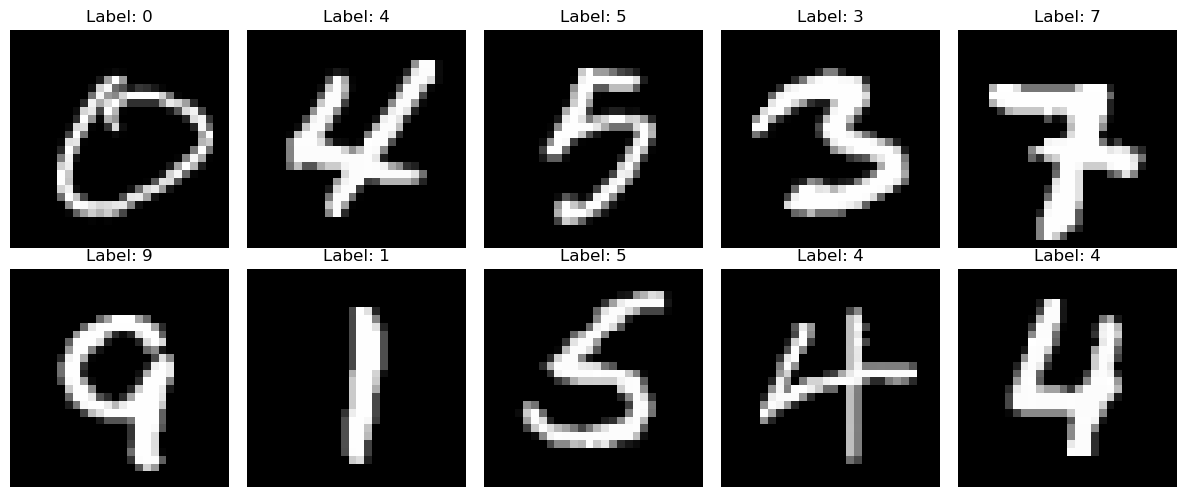

Dataset size: 60000
Testset size: 10000
Image shape: torch.Size([1, 28, 28])


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
train_data = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_data = torchvision.datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

# Display 10 random samples
for idx in range(10):
    # Get a random sample
    rand_idx = np.random.randint(0, len(train_data))
    image, label = train_data[rand_idx]

    # Convert tensor to numpy array and reshape
    image = image.squeeze().numpy()

    # Display the image
    axes[idx].imshow(image, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'Label: {label}')

plt.tight_layout()
plt.show()

# Print some basic information about the dataset
print(f"Dataset size: {len(train_data)}")
print(f"Testset size: {len(test_data)}")
print(f"Image shape: {train_data[0][0].shape}")

## Prepare Dataset

In [2]:
# Load MNIST dataset
def init_indices(train: bool):
    train_data = torchvision.datasets.MNIST(
        './data',
        train=train,
        download=False,
        transform=torchvision.transforms.ToTensor(),
    )

    digit_indices = {i: [] for i in range(10)}
    for idx in range(len(train_data)):
        image, label = train_data[idx]
        digit_indices[label].append(image)
    return digit_indices

In [3]:
from torch.utils.data import Dataset


class DigitDataset(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def add_item(self, image, label):
        self.images.append(image)
        self.labels.append(label)

    def shuffle(self):
        permutation = np.random.permutation(len(self.labels))
        new_images = []
        new_labels = []
        for p in permutation:
            new_images.append(self.images[p])
            new_labels.append(self.labels[p])
        self.images = new_images
        self.labels = new_labels

    def save(self, path):
        """Save dataset in compressed format"""
        torch.save({
            'images': self.images,
            'labels': self.labels
        }, path, _use_new_zipfile_serialization=True)
    
    @classmethod
    def load(cls, path):
        """Load dataset from compressed file"""
        data = torch.load(path)
        return cls(data['images'], data['labels'])

In [6]:
from collections import Counter

def plot_distributions(ax, sampled_dataset):
    digits = range(10)
    labels2 = [label for _, label in sampled_dataset]
    counts2 = Counter(labels2)
    frequencies2 = [counts2.get(d, 0) for d in digits]
    
    ax.bar(digits, frequencies2)
    ax.set_title('Label Distribution')
    ax.set_xlabel('Digit')
    ax.set_ylabel('Frequency')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

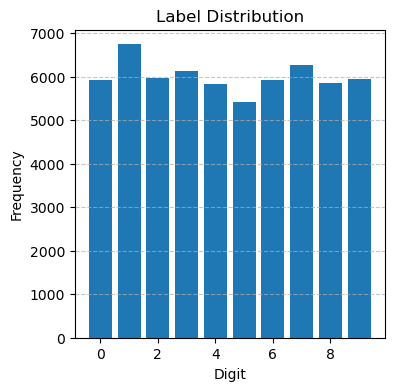

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_distributions(ax, train_data)
plt.show()

## Split Data

5923it [00:00, 456468.88it/s]
6742it [00:00, 1114403.85it/s]
5958it [00:00, 988984.61it/s]
6131it [00:00, 1224362.13it/s]
5842it [00:00, 1278535.04it/s]
5421it [00:00, 1210268.91it/s]
5918it [00:00, 1255660.21it/s]
6265it [00:00, 1240139.44it/s]
5851it [00:00, 1359153.34it/s]
5949it [00:00, 1375443.17it/s]


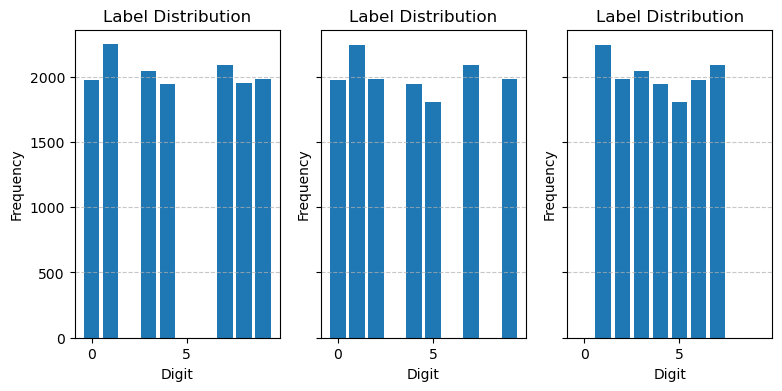

In [16]:
from tqdm import tqdm

indices = init_indices(True)
clients = [DigitDataset(), DigitDataset(), DigitDataset()]

ignored_labels = {
    0: (2, 5, 6),
    1: (3, 6, 8),
    2: (0, 8, 9),
}

for d in indices.keys():
    for i, digit_img in tqdm(enumerate(indices[d])):
        client_target = i % 3
        if d not in ignored_labels.get(client_target):
            clients[client_target].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(clients):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

5923it [00:00, 965146.18it/s]
6742it [00:00, 1071704.60it/s]
5958it [00:00, 1015385.93it/s]
6131it [00:00, 1248011.54it/s]
5842it [00:00, 910625.98it/s]
5421it [00:00, 817389.44it/s]
5918it [00:00, 1354684.88it/s]
6265it [00:00, 1132594.05it/s]
5851it [00:00, 1348029.26it/s]
5949it [00:00, 1314296.26it/s]


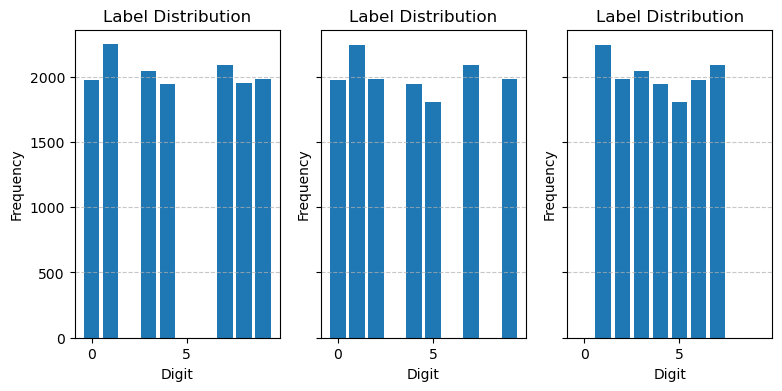

In [17]:
test_sets = [DigitDataset(), DigitDataset(), DigitDataset()]

for d in indices.keys():
    for i, digit_img in tqdm(enumerate(indices[d])):
        client_target = i % 3
        if d not in ignored_labels.get(client_target):
            test_sets[client_target].add_item(digit_img, d)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9, 4))

for i, client in enumerate(test_sets):
    client.shuffle()
    plot_distributions(axes[i], client)

plt.show()

In [19]:
import os
from pathlib import Path

data_dir = Path('mnist_data')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for i in range(3):
    clients[i].save(os.path.join(data_dir, f'site-{i + 1}.pt'))
    test_sets[i].save(os.path.join(data_dir, f'site-{i + 1}_test.pt'))

## Upload to S3

In [25]:
import boto3

sts_client = boto3.client('sts')
account_info = sts_client.get_caller_identity()
account_id = account_info['Account']

bucket_name = "flare-data-{}-site-{}"

s3 = boto3.client('s3')

for i in range(3):
    print(f'Uploading site-{i + 1}')
    s3.upload_file(
        data_dir / f'site-{i + 1}.pt',
        bucket_name.format(account_id, i + 1),
        f'site-{i + 1}.pt'
    )
    s3.upload_file(
        data_dir / f'site-{i + 1}_test.pt',
        bucket_name.format(account_id, i + 1),
        f'site-{i + 1}_test.pt'
    )

Uploading site-1
Uploading site-2
Uploading site-3
